In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rasterio
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
import pdb

In [81]:
os.getcwd()
os.chdir('/home/shoyo/Desktop')

In [149]:
# Set seed
seed = 42
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['CUDA_VISIBLE_DEVICES'] = " "
set_seed(42)

In [151]:
csv_path = os.getcwd() + '/SOC.csv'
df1 = pd.read_csv(csv_path)
df2 = df1[ (df1.EVI<-1) | (df1.EVI>1) ]

df = pd.DataFrame(columns=df1.columns)
for i in range(len(df1)):
    lat = df1.loc[i, 'latitude']
    lon = df1.loc[i, 'longitude']
    if not ((df2['latitude'] == lat) & (df2['longitude'] == lon)).any():
        # df = pd.concat([df, df1.loc[i]]) 
        df.loc[len(df)] = df1.iloc[i]
        # df = df.append(df1.loc[i]) 

df = df.drop(columns=['latitude', 'longitude', 'year', 'LC'])
df

,SOC,elev,slope,aspect,roughness,twi,SR_B2-1,SR_B3-1,SR_B4-1,SR_B5-1,...,SR_B4,SR_B5,SR_B6,SR_B7,EVI,ST_B10,VV,VH,VV/VH,prec
0,6.84225,1641,1.311631,47.303562,15.660496,-0.83046,0.166671,0.1916,0.207811,0.371354,...,0.310084,0.421857,0.312834,0.240069,0.20156,278.537831,0.100637,0.016779,5.997724,7.733378
1,5.94385,1634,5.549156,61.341667,12.340887,-1.442346,0.372605,0.421583,0.433325,0.565792,...,0.173285,0.317,0.238625,0.19193,0.208251,278.115705,0.081446,0.023201,3.510426,7.733378
2,4.4506,1626,5.39333,63.41954,13.694862,-1.242844,0.27762,0.305148,0.311541,0.404409,...,0.12505,0.309575,0.20645,0.191408,0.178394,279.735847,0.077992,0.012462,6.258336,7.733378
3,7.10625,1652,1.854871,54.527138,8.628444,-1.174888,0.367902,0.366472,0.369855,0.448093,...,0.252719,0.403735,0.277304,0.221039,0.216093,276.727989,0.066324,0.01395,4.754431,7.733378
4,7.06505,1629,3.340624,22.484619,12.107599,1.348318,0.242035,0.272423,0.284,0.40731,...,0.232974,0.373843,0.288648,0.22812,0.184308,274.041426,0.073882,0.013287,5.560403,7.733378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,11.6996,1281,5.845603,170.821472,12.704651,-1.521508,0.048146,0.138291,0.110736,0.371326,...,0.104879,0.425515,0.260776,0.17279,0.403028,262.857664,0.238391,0.047586,5.009638,19.454737
2250,17.2755,1280,2.073029,302.341278,13.376803,-1.125369,0.268132,0.291535,0.300802,0.484832,...,0.124349,0.423535,0.247604,0.167441,0.405969,263.734386,0.153898,0.036015,4.273174,19.454737
2251,16.5506,1273,1.854334,275.882629,16.946148,-1.232709,0.238762,0.297447,0.29764,0.49025,...,0.199644,0.465555,0.32404,0.250766,0.416291,263.725841,0.122215,0.025671,4.760748,19.454737
2252,11.2663,1269,3.818481,321.026031,11.025431,-1.183926,0.27674,0.27509,0.29247,0.469845,...,0.292649,0.484736,0.371766,0.263182,0.375307,263.180667,0.104044,0.019337,5.380625,19.454737


In [96]:
df = df.sample(frac=1, random_state=42)
scaler = MinMaxScaler()
n = len(df)

train_df = scaler.fit_transform(df[0:int(n*0.8)])
val_df = scaler.transform(df[int(n*0.8):int(n*0.9)])
test_df = scaler.transform(df[int(n*0.9):])
# train_df = scaler.fit_transform(df[:11760])
# val_df = scaler.transform(df[11760:(11760+1464)])
# test_df = scaler.transform(df[(11760+1464):])

Xtrain = train_df[:,1:]
Ytrain = train_df[:,0]

Xval = val_df[:,1:]
Yval = val_df[:,0]

Xtest = test_df[:,1:]
Ytest = test_df[:,0]

In [97]:
# (n_data, time_step, feature)
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xval = np.reshape(Xval, (Xval.shape[0], 1, Xval.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))

# (n_data, time_step)
Ytrain = np.reshape(Ytrain, (Ytrain.shape[0], 1))
Yval = np.reshape(Yval, (Yval.shape[0], 1))
Ytest = np.reshape(Ytest, (Ytest.shape[0],1))

In [98]:
df.apply(['mean', 'median', 'max', 'min', 'std', 'skew', 'count']).transpose()

,mean,median,max,min,std,skew,count
SOC,10.216712,7.784500,119.511800,1.612800,10.852877,4.491025,2254.0
elev,1020.733807,1111.000000,2022.000000,-3.000000,481.673781,-0.659139,2254.0
slope,3.358222,2.624617,44.433758,0.000000,3.346664,4.175273,2254.0
aspect,167.385410,159.216858,359.977112,0.032219,105.642955,0.204287,2254.0
roughness,8.799856,4.935846,157.365005,0.215358,12.780057,4.566025,2254.0
twi,0.680638,0.221288,10.531526,-3.706729,2.029255,1.504489,2254.0
SR_B2-1,0.194438,0.142877,0.696858,0.003115,0.149251,0.864834,2254.0
SR_B3-1,0.240076,0.204504,0.676673,0.033406,0.130167,0.803528,2254.0
SR_B4-1,0.255870,0.222276,0.659952,0.039305,0.131604,0.694178,2254.0
SR_B5-1,0.395033,0.388541,0.698562,0.095735,0.100562,0.290040,2254.0


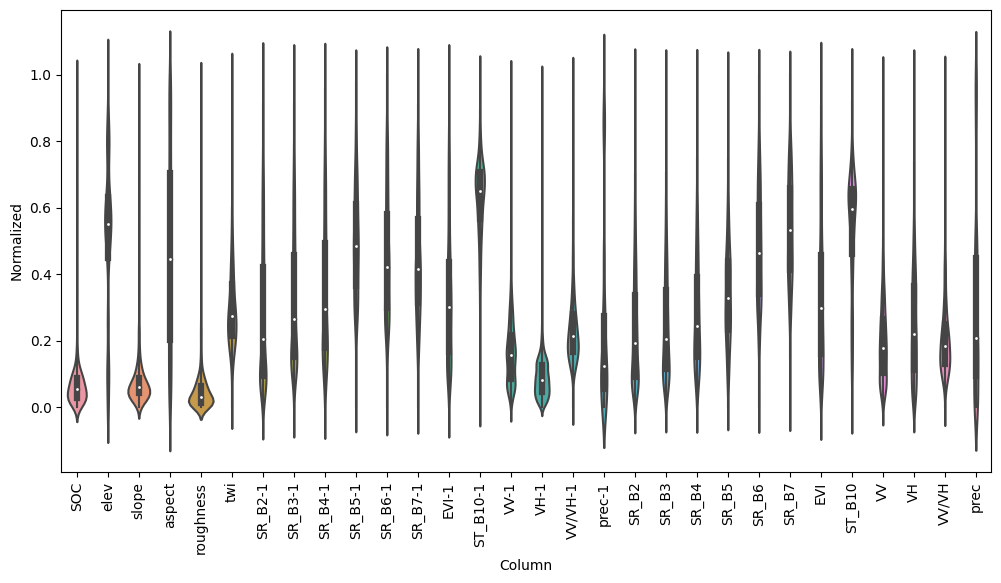

In [99]:
df_std = pd.DataFrame(train_df).melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [215]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)
batch_size = [128, 256, 512, 1024]
units = [32, 64, 128, 256]
units_dense = 1
lr = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
epochs = 1000
info = pd.DataFrame(columns=['batchsize', 'unit', 'learningrate', 'model', 'rmse', 'r2'])
i = 0

for batchSize in batch_size:
    for unit in units:
        for learningRate in lr:

            model1 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], kernel_initializer=initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')])
            
            model2 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], return_sequences=True, kernel_initializer=initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')])

            model3 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], return_sequences=True, kernel_initializer=initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/4), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')
            ])

            model4 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], return_sequences=True, kernel_initializer=initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/4), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/8), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')
            ])
            
            for j in range(4):
                model = [model1, model2, model3, model4][j]
                
                print(i)

                model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
                    metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.RootMeanSquaredError()
                            ])

                # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
                early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

                history = model.fit(Xtrain, Ytrain, 
                                    epochs=epochs, 
                                    batch_size=batchSize,
                                    validation_data=(Xval, Yval), 
                                    callbacks=[early_stopping]
                                    )
                Ypred = model.predict(Xval)
                Ypred=np.reshape(Ypred, Yval.shape)
                mse = mean_squared_error(Yval, Ypred)
                print("RMSE", math.sqrt(mse))
                mae = mean_absolute_error(Yval, Ypred)
                print("MAE", mae)
                R_square = r2_score(Yval, Ypred) 
                print('Coefficient of Determination', R_square) 

                addCol = pd.Series( [ batchSize, unit, learningRate, str(j+1), math.sqrt(mse), R_square ],
                       index=info.columns 
                       )
                
                info.loc[i] = addCol

                i=i+1

print(info)
info.to_csv(os.getcwd() + '/info.csv', index=False)

2023-05-30 18:11:10.256120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 18:11:10.258254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 18:11:10.259627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

0
Epoch 1/1000


2023-05-30 18:11:12.337080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 18:11:12.338438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 18:11:12.340120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 9/15 [=================>............] - ETA: 0s - loss: 0.5649 - mean_absolute_error: 0.4778 - root_mean_squared_error: 0.7516 

2023-05-30 18:11:15.643050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [225,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:15.643424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [225,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:15.853693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

15/15 [==============================] - 4s 46ms/step - loss: 0.3713 - mean_absolute_error: 0.3536 - root_mean_squared_error: 0.6093 - val_loss: 0.0050 - val_mean_absolute_error: 0.0519 - val_root_mean_squared_error: 0.0706
Epoch 2/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.0159 - mean_absolute_error: 0.0913 - root_mean_squared_error: 0.1260 - val_loss: 0.0041 - val_mean_absolute_error: 0.0557 - val_root_mean_squared_error: 0.0639
Epoch 3/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.0101 - mean_absolute_error: 0.0650 - root_mean_squared_error: 0.1003 - val_loss: 0.0025 - val_mean_absolute_error: 0.0406 - val_root_mean_squared_error: 0.0503
Epoch 4/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0555 - root_mean_squared_error: 0.0933 - val_loss: 0.0030 - val_mean_absolute_error: 0.0463 - val_root_mean_squared_error: 0.0552
Epoch 5/1000
15/15 [==============================] - 0s 6ms/step - 

2023-05-30 18:11:23.692242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [225,1,29]
	 [[{{node Placeholder/_10}}]]
2023-05-30 18:11:23.692544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [225,1,29]
	 [[{{node Placeholder/_10}}]]


1/8 [==>...........................] - ETA: 2s

2023-05-30 18:11:23.929922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 18:11:23.932130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 18:11:23.933565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 0s 3ms/step
RMSE 0.035351340716621354
MAE 0.025581644650455516
Coefficient of Determination 0.43404706392911807
1
Epoch 1/1000


2023-05-30 18:11:24.215062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1803,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:24.215423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1803,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:24.478357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

13/15 [=========================>....] - ETA: 0s - loss: 0.7004 - mean_absolute_error: 0.5675 - root_mean_squared_error: 0.8369

2023-05-30 18:11:28.454405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [225,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:28.454770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [225,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:28.696562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

15/15 [==============================] - 5s 74ms/step - loss: 0.6532 - mean_absolute_error: 0.5421 - root_mean_squared_error: 0.8082 - val_loss: 0.0051 - val_mean_absolute_error: 0.0626 - val_root_mean_squared_error: 0.0712
Epoch 2/1000
15/15 [==============================] - 0s 11ms/step - loss: 0.0334 - mean_absolute_error: 0.1369 - root_mean_squared_error: 0.1828 - val_loss: 0.0025 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0500
Epoch 3/1000
15/15 [==============================] - 0s 10ms/step - loss: 0.0159 - mean_absolute_error: 0.0884 - root_mean_squared_error: 0.1260 - val_loss: 0.0025 - val_mean_absolute_error: 0.0413 - val_root_mean_squared_error: 0.0503
Epoch 4/1000
15/15 [==============================] - 0s 10ms/step - loss: 0.0108 - mean_absolute_error: 0.0657 - root_mean_squared_error: 0.1037 - val_loss: 0.0025 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0502
Epoch 5/1000
15/15 [==============================] - 0s 8ms/step

2023-05-30 18:11:37.924130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [225,1,29]
	 [[{{node Placeholder/_10}}]]
2023-05-30 18:11:37.924539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [225,1,29]
	 [[{{node Placeholder/_10}}]]
2023-05-30 18:11:38.163885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

8/8 [==============================] - 1s 4ms/step
RMSE 0.036241849602205674
MAE 0.02688812387153591
Coefficient of Determination 0.40517495471884535
2
Epoch 1/1000


2023-05-30 18:11:38.854043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1803,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:38.854388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1803,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:39.104631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

11/15 [=====================>........] - ETA: 0s - loss: 0.4194 - mean_absolute_error: 0.4363 - root_mean_squared_error: 0.6476 

2023-05-30 18:11:44.803480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [225,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:44.803951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [225,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:11:45.057841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

15/15 [==============================] - 7s 110ms/step - loss: 0.3374 - mean_absolute_error: 0.3771 - root_mean_squared_error: 0.5808 - val_loss: 0.0057 - val_mean_absolute_error: 0.0672 - val_root_mean_squared_error: 0.0755
Epoch 2/1000
15/15 [==============================] - 0s 15ms/step - loss: 0.0169 - mean_absolute_error: 0.0881 - root_mean_squared_error: 0.1300 - val_loss: 0.0037 - val_mean_absolute_error: 0.0515 - val_root_mean_squared_error: 0.0605
Epoch 3/1000
15/15 [==============================] - 0s 15ms/step - loss: 0.0096 - mean_absolute_error: 0.0562 - root_mean_squared_error: 0.0978 - val_loss: 0.0027 - val_mean_absolute_error: 0.0419 - val_root_mean_squared_error: 0.0521
Epoch 4/1000
15/15 [==============================] - 0s 16ms/step - loss: 0.0095 - mean_absolute_error: 0.0534 - root_mean_squared_error: 0.0972 - val_loss: 0.0023 - val_mean_absolute_error: 0.0375 - val_root_mean_squared_error: 0.0481
Epoch 5/1000
15/15 [==============================] - 0s 15ms/st

In [213]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)
batch_size = 128
unit = 64
units_dense = 1
lr = 0.005
epochs = 1000

model1 = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], kernel_initializer=initializer),
            tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.Lambda(lambda x: tf.keras.layers.Dropout(0.2, seed=seed)(x)),
            tf.keras.layers.Dense(units_dense, activation='linear')])
            
model2 = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], return_sequences=True, kernel_initializer=initializer),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.LSTM(int(unit/2), return_sequences=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.Dense(units_dense, activation='linear')])

model3 = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], return_sequences=True, kernel_initializer=initializer),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.LSTM(int(unit/4), return_sequences=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.Dense(units_dense, activation='linear')
            ])

model4 = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], return_sequences=True, kernel_initializer=initializer),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.LSTM(int(unit/4), return_sequences=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.LSTM(int(unit/8), return_sequences=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2, seed=42),
            tf.keras.layers.Dense(units_dense, activation='linear')
            ])

model = model1

2023-05-30 18:08:06.636314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 18:08:06.638898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 18:08:06.640457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [214]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                       tf.keras.metrics.RootMeanSquaredError()
                       ])

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

history = model.fit(Xtrain, Ytrain, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(Xval, Yval), 
                    callbacks=[early_stopping]
                    )

Epoch 1/1000


2023-05-30 18:08:13.235093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1803,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:08:13.235410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1803,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:08:13.473512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

 9/15 [=================>............] - ETA: 0s - loss: 0.2649 - mean_absolute_error: 0.3840 - root_mean_squared_error: 0.5146 

2023-05-30 18:08:15.556972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [225,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:08:15.557340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [225,1]
	 [[{{node Placeholder/_11}}]]
2023-05-30 18:08:15.772293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

15/15 [==============================] - 3s 42ms/step - loss: 0.2158 - mean_absolute_error: 0.3439 - root_mean_squared_error: 0.4645 - val_loss: 0.0019 - val_mean_absolute_error: 0.0321 - val_root_mean_squared_error: 0.0441
Epoch 2/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.0913 - mean_absolute_error: 0.2280 - root_mean_squared_error: 0.3021 - val_loss: 0.0020 - val_mean_absolute_error: 0.0343 - val_root_mean_squared_error: 0.0444
Epoch 3/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.0460 - mean_absolute_error: 0.1645 - root_mean_squared_error: 0.2144 - val_loss: 0.0033 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0576
Epoch 4/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.0259 - mean_absolute_error: 0.1241 - root_mean_squared_error: 0.1611 - val_loss: 0.0024 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0490
Epoch 5/1000
15/15 [==============================] - 0s 9ms/step - 

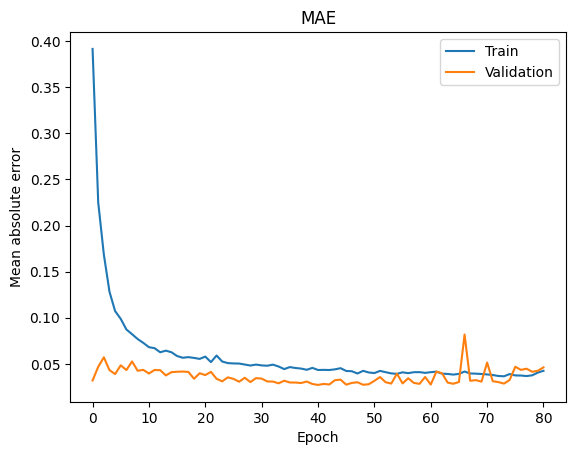

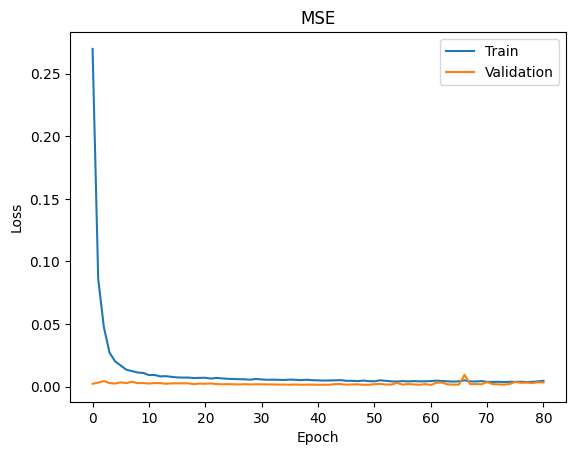

In [143]:
# Plot the training and validation accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [211]:
Ypred = model.predict(Xtest)
Ypred=np.reshape(Ypred, Ytest.shape)
print('shape', Ypred.shape)
print(Ypred[:10], np.max(Ypred), np.min(Ypred))

2023-05-30 18:07:56.130851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [226,1,29]
	 [[{{node Placeholder/_10}}]]
2023-05-30 18:07:56.131206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [226,1,29]
	 [[{{node Placeholder/_10}}]]
2023-05-30 18:07:56.387173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

8/8 [==============================] - 0s 3ms/step
shape (226, 1)
[[0.07445323]
 [0.05622545]
 [0.04658894]
 [0.03532048]
 [0.06020261]
 [0.07899971]
 [0.06300285]
 [0.09086306]
 [0.08417153]
 [0.07861845]] 0.27155358 0.017750904


In [212]:
mse = mean_squared_error(Ytest, Ypred)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(Ytest, Ypred)
print("MAE", mae)
R_square = r2_score(Ytest, Ypred) 
print('Coefficient of Determination', R_square) 

RMSE 0.05454981544938082
MAE 0.031883102822969286
Coefficient of Determination 0.4796689330556616


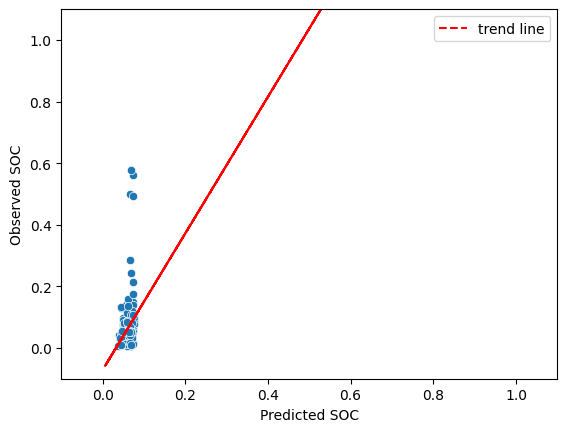

In [107]:
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(Ytest))
z = np.polyfit(np.squeeze(Ypred), np.squeeze(Ytest), 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(Ytest), p(np.squeeze(Ytest)), "r--", label='trend line')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()

In [44]:
# Save the trained model
model.save(os.getcwd() + '/LSTM', save_format='tf')

2023-05-30 14:41:27.119282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 14:41:27.122334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 14:41:27.123938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: /home/shoyo/Desktop/LSTM/assets


INFO:tensorflow:Assets written to: /home/shoyo/Desktop/LSTM/assets


In [567]:
model = tf.keras.models.load_model(os.getcwd() + '/LSTM') 

2023-05-29 16:26:17.314241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-05-29 16:26:17.314422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-05-29 16:26:17.314525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus